#### Recording ECG with Polar H10

In [1]:
# Reading in Polar H10 data to make a prediction
import asyncio
from bleak import BleakScanner
from PolarH10 import PolarH10
from tqdm import tqdm
import matplotlib.pyplot as plt

async def main(record_len):
    devices = await BleakScanner.discover()
    polar_device_found = False
    ecg_data = None

    for device in devices:
        if device.name is not None and "Polar" in device.name:
            polar_device_found = True
            polar_device = PolarH10(device)
            await polar_device.connect()
            await polar_device.get_device_info()
            await polar_device.print_device_info()

            await polar_device.start_ecg_stream()
            for i in tqdm(range(record_len), desc='Recording...'):
                await asyncio.sleep(1)
            await polar_device.stop_ecg_stream()

            ecg_data = polar_device.get_ecg_data()
            
            await polar_device.disconnect()
    
    if not polar_device_found:
        print("No Polar device found")

    return ecg_data

record_len = 60 # s

ecg_data = await main(record_len)

Model Number: H10 
Manufacturer Name: Polar Electro Oy 
Serial Number: 79324520 
Address: F3:6D:6E:2F:7C:18
Battery Level: 100%
Firmware Revision: 5.0.0 
Hardware Revision: 00760690.03 
Software Revision: 3.1.1 


Recording...: 100%|██████████| 60/60 [01:00<00:00,  1.00s/it]

Stopping ECG data...


651


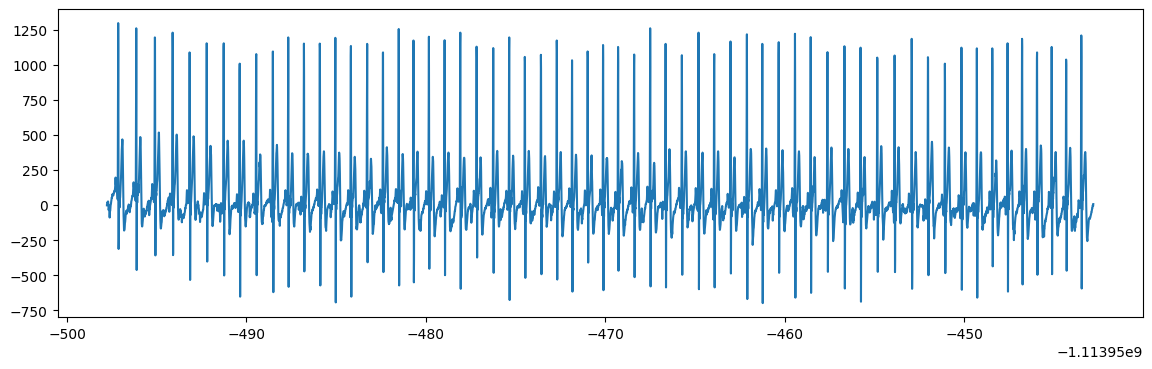

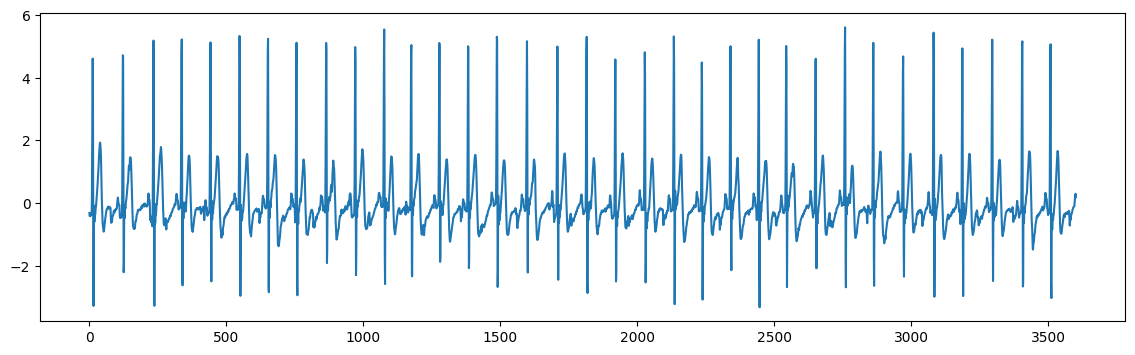

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from preprocessing import lowpass_fir_record, resample_record, normalise_record, crop_random_and_pad_sample

times = ecg_data['times']
ecg = ecg_data['values']
fs = 1/np.mean(np.diff(times))
start_id = int(5*fs) # remove the first 5 seconds
print(start_id)
times = times[start_id:]
ecg = ecg[start_id:]

plt.figure(figsize=(14,4))
plt.plot(times, ecg)
plt.show()

resample_fs = 120
order = 512
cutoff = 60
crop_length = 30
ecg_lp = lowpass_fir_record(ecg, fs, order, cutoff)
ecg_rs = resample_record(ecg_lp, fs, resample_fs)
ecg_n = normalise_record(ecg_rs, np.mean(ecg), np.std(ecg))
sample = crop_random_and_pad_sample(ecg_n, resample_fs, crop_length)

plt.figure(figsize=(14,4))
plt.plot(sample)


(1, 3601, 1)
1/1 [==============================] - 0s 145ms/step
Normal


Text(0.5, 1.0, 'Prediction: Normal')

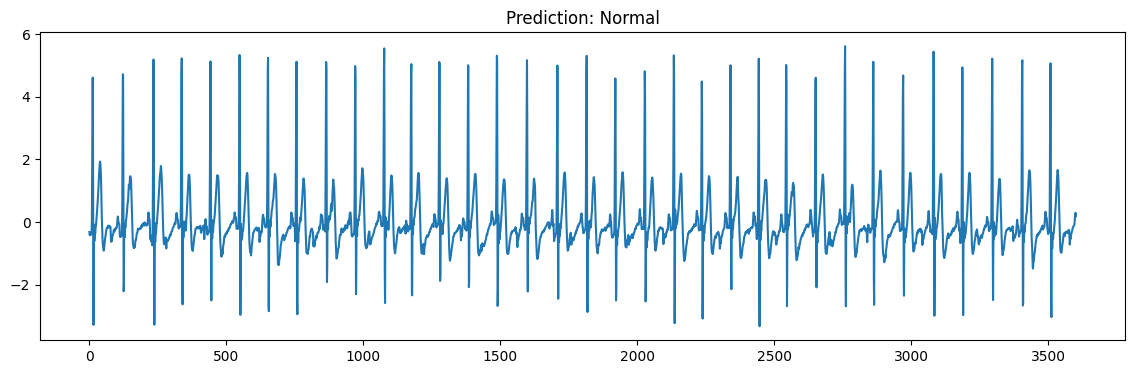

In [12]:
import matplotlib.pyplot as plt
from modelling import create_dual_stream_cnn_model
import tensorflow as tf

X = np.expand_dims(np.expand_dims(sample, -1), 0)
print(X.shape)

# Load the model
models_path = "models/20240418_185203/fold_9_model_weights.h5"
model = create_dual_stream_cnn_model((X.shape[1], 1), stream2_size=5, verbose=0)
model.load_weights(models_path)

prediction = model.predict(X)
predicted_class = "Atrial Fibrillation" if prediction >=0.5 else "Normal"
tf.keras.backend.clear_session()

print(predicted_class)
plt.figure(figsize=(14,4))
plt.plot(X.flatten())
plt.title(f"Prediction: {predicted_class}")

#### Pre-recorded ECG from .edf file

In [14]:
########################################
# EDF files - Reading in data from "Polar H10 ECG Analysis" App
########################################
import pyedflib
import plotly.express as px
import numpy as np

edf_dir = 'data/polarh10/'
# edf_file = 'mike100s_2024-02-14_12-02-33.edf'
edf_file = 'kieran_2024-02-13_13-00-12.edf' 
file_path = edf_dir + edf_file
# edf_file_path = 'kieran_2024-02-13_13-00-12.edf' 

def read_ecg_from_edf(file_path):
    '''
    Reads an ecg signal from an edf file given the file path
    EDF is European Data Format, a standard format for medical time series, and exportable from the Polar H10 ECG Analysis App
    Returns a tuple of t and signal both as numpy arrays. t is derived from the sample rate
    '''

    with pyedflib.EdfReader(file_path) as edf:
        # Get the number of signals in the file
        n = edf.signals_in_file
        
        #  Assuming one signal
        ecg = edf.readSignal(0)
        fs = edf.getSampleFrequency(0)
        print(f"EDF file sample rate: {fs}")

        dt = 1/fs
        t = np.arange(0,dt*(len(ecg)), dt)
        signal_ids = t > 5 # Remove first 5 seconds
        ecg = ecg[signal_ids]
        t = t[signal_ids]
        t = t - t[0]

    return (t, ecg)
times, ecg = read_ecg_from_edf(file_path)
print(times.shape, ecg.shape)
px.line(x=times, y=ecg)

EDF file sample rate: 260.0
(11179,) (11179,)


In [15]:
from preprocessing import lowpass_fir_record, resample_record, normalise_record, crop_random_and_pad_sample
import numpy as np
# Lowpass filter and resample
fs = 260
resample_fs = 120
order = 512
cutoff = 60
crop_length = 30
ecg_lp = lowpass_fir_record(ecg, fs, order, cutoff)
ecg_rs = resample_record(ecg_lp, fs, resample_fs)
ecg_n = normalise_record(ecg_rs, np.mean(ecg), np.std(ecg))

# Crop and pad
sample = crop_random_and_pad_sample(ecg_n, resample_fs, crop_length)
px.line(y=sample)

(1, 3601, 1)
1/1 [==============================] - 0s 145ms/step
Normal


Text(0.5, 1.0, 'Prediction: Normal')

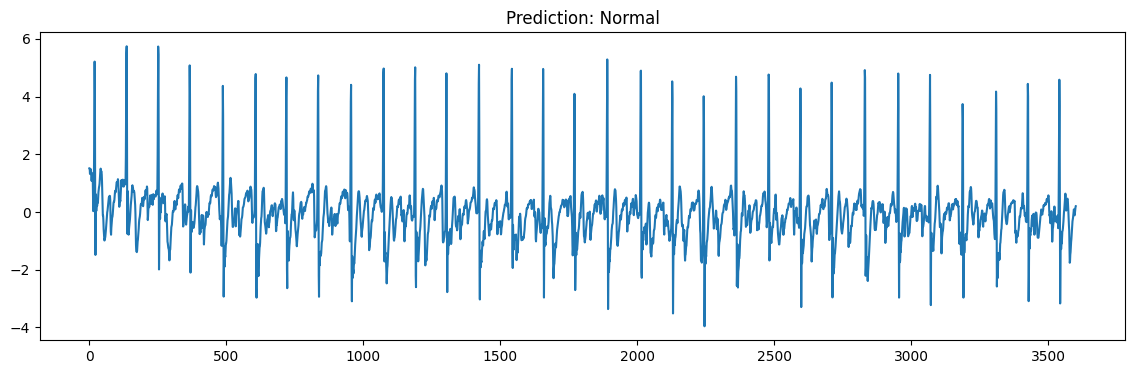

In [16]:
import matplotlib.pyplot as plt
from modelling import create_dual_stream_cnn_model
import tensorflow as tf

X = np.expand_dims(np.expand_dims(sample, -1), 0)
print(X.shape)

# Load the model
models_path = "models/20240418_185203/fold_9_model_weights.h5"
model = create_dual_stream_cnn_model((X.shape[1], 1), stream2_size=5, verbose=0)
model.load_weights(models_path)

prediction = model.predict(X)
predicted_class = "Atrial Fibrillation" if prediction >=0.5 else "Normal"
tf.keras.backend.clear_session()

print(predicted_class)
plt.figure(figsize=(14,4))
plt.plot(X.flatten())
plt.title(f"Prediction: {predicted_class}")

In [ ]:
# # Count the number of pvc events in a 30 minute period
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# arch = 'resnet18'
# weights_file = 'jobs/beat_classification/20240210-121426/epoch_06/model.weights'
# frame_size = 2048
# model = load_beat_model(weights_file, arch, frame_size)

# # Read in file
# edf_dir = 'data/polarh10/'
# edf_file = 'mike30m_2024-02-16_09-29-39.edf'
# file_path = edf_dir + edf_file
# times, ecg = read_ecg_from_edf(file_path)
# resample_rate = 250 # Hz

# # Resample and normalise
# times_up, ecg_up = resample_ecg(ecg, times, resample_rate)
# ecg_up = noramlise_ecg(ecg_up)

# # Create frames with a certain overlap
# frame_overlap = 20
# frame_starts = range(0, len(ecg_up), frame_size - frame_overlap)
# predictions = []

# # frame_starts = frame_starts[0:5]

# # fig, axes = plt.subplots(len(frame_starts))
# # fig.set_size_inches(14, 20)

# for id, frame_start in tqdm(enumerate(frame_starts), total=len(frame_starts)):
#     x = select_ecg_frame_for_model(ecg_up, frame_start, frame_size)
#     predictions.append(predict_beat_label(model, np.expand_dims(x, axis=0))) # input shape of the model (1, 2048, 1)
    
#     # axes[id].plot(x)
#     # axes[id].set_ylabel(prediction[id])
#     # axes[id].xaxis.set_ticklabels([])
#     # axes[id].yaxis.set_ticklabels([])

In [ ]:
from collections import Counter
# Count the number of each class

label_count = Counter(predictions)
print(label_count)
percent_pvc = 100*label_count['pvc']/(label_count['normal'] + label_count['pvc'])
print(f"Percent pvc: {percent_pvc:.1f}%")